Introduction:

We're using the UCI Credit Approval Dataset https://archive.ics.uci.edu/dataset/27/credit+approval and build a Logistic Regression Model that generalizes well and can be used to accurately classify whether if a person applying for credit will be aproved or not. We're using Logistic Regression because it does a good job for models that have binary target variables that's 0 or 1 (rejected or approved for credit)

I'm interested in this because I'm interested in finance and credit is very important in facilatitating business transactions, consumer spending, investments, and so on.



In [1]:
## Imports
# Read the data file
import pandas as pd
df = pd.read_csv('./crx.data', header=None, na_values="?")
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
import numpy as np # optional: autograd.numpy (not needed for our purposes right now)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, LayerNormalization, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
# Assign columns A1 to A16
df.columns = [f"A{i+1}" for i in range(df.shape[1])]

# Rename the last column to 'A16 (Class)'
df.rename(columns={"A16": "A16 (Class)"}, inplace=True)

categorical_preview_cols = df.select_dtypes(include=['object']).columns.tolist()

# Strip and map only valid class values and map +/- into 1/0
df["A16 (Class)"] = df["A16 (Class)"].astype(str).str.strip().map({'+': 1, '-': 0})

print("\n",df.shape[0], "rows ×", df.shape[1], "columns")


 690 rows × 16 columns


In [3]:
# Check how many Missing (NaN) values rows there are for each column/predictor variables
df_nas = df.isna().sum()
print(df_nas[df_nas>0])

# we only lose at least 13 out of 690 rows that have missing values, so we drop them
df_clean = df.dropna()
print("\n",df_clean.shape[0], "rows ×", df_clean.shape[1], "columns")
df_clean.head()

A1     12
A2     12
A4      6
A5      6
A6      9
A7      9
A14    13
dtype: int64

 653 rows × 16 columns


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16 (Class)
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [4]:
# Count rows with *any* NA (for overlaps)
print(df.isna().any(axis=1).sum())

37


In [5]:
# Check NA distribution by target class (0 or 1)
print(df[df.isna().any(axis=1)]['A16 (Class)'].value_counts())

A16 (Class)
0    26
1    11
Name: count, dtype: int64


In [6]:
# Class distribution before dropping NAs
print("Before dropping NAs:")
print(df['A16 (Class)'].value_counts())

# Class distribution after dropping NAs
print("\nAfter dropping NAs:")
print(df.dropna()['A16 (Class)'].value_counts())

Before dropping NAs:
A16 (Class)
0    383
1    307
Name: count, dtype: int64

After dropping NAs:
A16 (Class)
0    357
1    296
Name: count, dtype: int64



# TO BE EDITED:

What This Means:
No Overlap Between NAs and Target

The result is an empty Series, which means none of the rows with missing values (NAs) have a missing/NA value in the Target column.

In other words, your Target column is complete (no NAs), and the 37 rows with NAs are only missing values in the predictor columns (A1, A2, A4, etc.).

Good News

Since Target has no NAs, dropping rows won’t directly bias your outcome variable.

However, you should still check if the 37 NA rows are disproportionately from one class (e.g., more + or - cases being dropped).

In [7]:
# If keeping the dropped version (653 rows)
df_clean = df.dropna()

##### DELETE THIS LATER:
# # If imputing instead (keeps all 690 rows)
# from sklearn.impute import SimpleImputer

### To justify dropping, we first check distributions of classes before and after

# Numeric columns (median)
num_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical columns (mode)
cat_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
# Remove this: # df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [8]:
# Check distribution after imputation
print(df['A16 (Class)'].value_counts(normalize=True))

A16 (Class)
0    0.555072
1    0.444928
Name: proportion, dtype: float64


In [9]:
df_clean = df.dropna()
print(df_clean['A16 (Class)'].value_counts(normalize=True))

# A16 (Class)
# 0    0.546708
# 1    0.453292

A16 (Class)
0    0.552906
1    0.447094
Name: proportion, dtype: float64


In [10]:
# # OPTIONAL: Imputation instead of dropping NA's
# # Fill NA with median/mode (imputation)
# df_imputed = df.copy()
# df_imputed[num_cols] = df_imputed[num_cols].fillna(df[num_cols].median())
# df_imputed[cat_cols] = df_imputed[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# print("\nAfter imputation (no rows dropped):")
# print(df_imputed['A16 (Class)'].value_counts(normalize=True))

# TO BE EDITED:
Very minimal shift toward approvals. Likely acceptable for most models.

Since the class shift is negligible after dropping NaN rows, dropping NAs is simpler for our model building hereon out.

In [11]:
# Drop rows with NAs
df_clean = df.dropna().copy()  # Now has 653 rows (from 690)

# Separate features (X) and target (y)
X = df_clean.drop('A16 (Class)', axis=1)  # All predictor columns
y = df_clean['A16 (Class)']              # Target (0=denied, 1=approved)

To preprocess our data we use One-Hot Encoding to include categorical variables. Categorical Columns (based on UCI dataset description):
A1, A4, A5, A6, A7, A9, A10, A12, A13. (Note: Verify by checking dtypes with X.dtypes for "object" dtypes)

In [12]:
# X.dtypes

One-hot encoding creates binary (0/1) features for each category and we use drop='first' to drop the first binary column in order to avoid multicollinearity.

In [13]:
# Categorical columns (adjust based on your dataset)
categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

# Numeric columns (standardize later)
numeric_cols = X.columns.difference(categorical_cols).tolist()

# ColumnTransformer for encoding categoricals and keep numericals unchanged/untransformed.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ])

X_processed = preprocessor.fit_transform(X)

We standardize numeric features to ensure equal feature scaling of the numeric features, since some features may be large such as for example income, etc. that often have different units in the thousands, even hundreds of thousands. Standardizing puts them on the same scale (mean=0, std=1), in order to prevent features with larger magnitudes from dominating the model.

Also, models like neural networks use gradient descent, which converges faster when features are standardized.

In [14]:
# Standardize numeric features (after one-hot encoding)
scaler = StandardScaler()
X_processed[:, len(preprocessor.named_transformers_['cat'].get_feature_names_out()):] = \
    scaler.fit_transform(X_processed[:, len(preprocessor.named_transformers_['cat'].get_feature_names_out()):])

Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=69, stratify=y)
# stratify = y is to evenly distribute the values of y in each split.

#### 2. Build the Neural Network

1st hidden layer: 64 neurons ReLU activation function to learn complex patterns from input features. \
2nd hidden layer: 32 neurons ReLU to refine the learned representations. \
Both with 30% Dropout, which randomly sets 30% of the layer's outputs to 0 during training. We use a moderate 30% to prevent overfitting to training data noise, any higher would risk underfitting and any lower may not prevent overfitting. \

Sigmoid activation in the outer layer, which makes the outputs to [0,1] range, which is what we need for binary classification (credit approval: 0=reject, 1=approve).

OPTONAL: Since batch size will likely be small with 653 data samples (after NaN removed) instead of using batch normalization for stable training we could use Layer normalization, but loss and accuracy seems relatively stable without it, so we refrain from using it for now.

Our model has:
1st Hidden layer for processing the input data (aka. Input layer): 64 neurons [ expecting 37 features, so 2432 params = (37 inputs * 64 neurons) + 64 biases ] \
2nd Hidden layer: 32 neurons, so 2080 params = (64 inputs * 32 neurons) + 32 biases \
Output Layer: 1 neuron, so 33 params = 32 inputs * 1 neuron + 1 Bias (sigmoid for binary classification)

Total params: 4,545

We use learning rate = 0.001 since it is the standard initial learning rate for the Adam optimizer because it’s small enough to avoid overshooting optimal weights (divergence) and large enough to make meaningful progress without being impractically slow. Can Decrease if loss oscillates or diverges.

And we use binary_crossentropy to measure the difference between predicted probabilities (sigmoid outputs) and true binary labels (0 or 1).

In [16]:
# Get input shape (number of features after encoding)
input_shape = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),  # Reduce overfitting
    
    Dense(32, activation='relu'),
    Dropout(0.3), 
    Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
# model.summary()

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.9
# )
# optimizer = Adam(learning_rate=lr_schedule)
# model.compile(
#     optimizer=optimizer,
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# )


<!-- ### OPTIONAL: Layer Normalization vs Batch Normalization, (here in this small sample size Layer Norm > Batch Norm)


# # Get input shape (number of features after encoding)
# input_shape = X_train.shape[1]

# model = Sequential([
#     Dense(64, activation='relu', input_shape=(input_shape,)),
#     # LayerNormalization(),  # Safer than BatchNorm here
#     Dropout(0.3),  # Reduce overfitting
    
#     Dense(32, activation='relu'),
#     # LayerNormalization(),  # Safer than BatchNorm here
#     Dropout(0.3), 
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# )

# model.summary()




# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
# from tensorflow.keras.optimizers import Adam
# import tensorflow as tf

# model = Sequential([
#     Dense(64, use_bias=False, input_shape=(X_train.shape[1],)),
#     BatchNormalization(),
#     ReLU(),  # Explicit ReLU layer
#     Dropout(0.3),
    
#     Dense(32, use_bias=False),
#     BatchNormalization(),
#     ReLU(),
#     Dropout(0.3),
    
#     Dense(1, activation='sigmoid')
# ])

# # Compile with Adam optimizer and metrics
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.AUC(name='auc')  # For credit risk evaluation
#     ]
# )
# # Model summary
# model.summary() -->

#### 3. Train the Model
To prevent overfitting we use EarlyStopping to stop training when the model stops improving on validation data.

Key Parameters:\
patience=5: the model will wait and run for 5 epochs without improvement before stopping the training. It monitors val_loss by default (or another metric if specified). If there's no improvement for 5 patience epochs, training will stop. \

restore_best_weights=True: Revert to the model weights from the epoch with the best validation performance when we do stop training.\
We choose a reasonable 50 epochs for a small to medium sized dataset, this is sufficient for convergence without overfitting. \ 

And 32 batch size as smaller batches offer more frequent updates, helping your model escape poor local minima, 32 is best balance of stability and efficiency as it has smoother gradients than lower batch sizes, i.e. faster convergence as it handles noise better, although it comes at a slightly higher risk of overfitting. 16 would be better for smaller datasets and more complex models, whereas 32 is fine for medium sized and simpler models. \

And we address the class imbalance during training by making the model pay more attention to the under-represented class, since otherwise the model may be biased towards one class. Weights adjust the loss function to penalize errors on the minority class more heavily.

In [17]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=32,
#     class_weight={0: 0.55, 1: 0.45}, verbose = 0  # Adjust for class imbalance
# )
    
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight={0: 0.55, 1: 0.45}, callbacks = callbacks, verbose = 0  # class_weight to adjust for class imbalance
)

#### Plot Training History


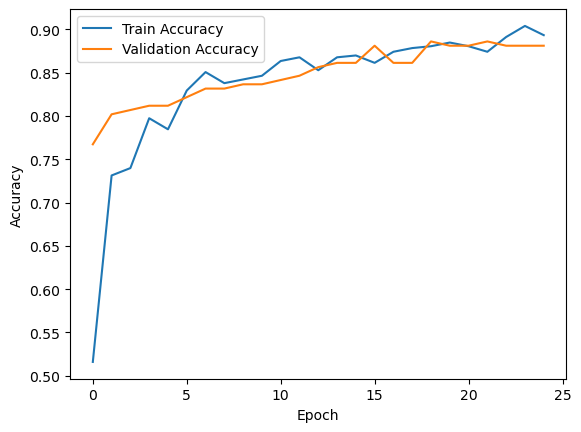

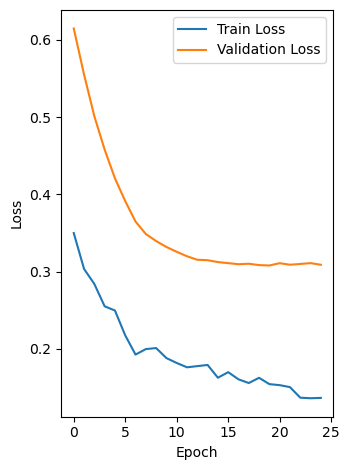

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.tight_layout()
plt.show()

#### Comments:
Initial sharp increase in improvement of accuracy where there's rapid learning of easy patterns (such as very obvious and clear-cut approval/rejection cases). Then after a few epochs we have gradual increase : where the model learns finer, more complex patterns. The convergence of the gap between training and validation(test) accuracy after a certain number of epochs implies reduced overfitting as the model stabilizes, the initial divergence in gap of accuracy is normal as the model transitions from memorizing noise to learning generalizable patterns.

Loss seems stable and steady, accuracy is somewhat erratic/rough (not very smooth) due to slight fluctuations due to randomness but it's still relatively stable enough to learn patterns to generalize well.

#### 4. Evaluate the Model

In [19]:
# Evaluate on test data
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")  # AUC > 0.8 is good, ideally we want > 0.9 which is excellent

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int) # threshold > 0.5 default for binary classifications

7/7 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8812 - auc: 0.9397
Test Accuracy: 0.88
AUC: 0.94
7/7 [==============================] - 0s 597us/step


##### Comment:
AUC = 0.94 > 0.9: Excellent at discriminating between the two classes  (far better than random guessing (0.5)).

Test Accuracy approx. 87%: Good, Model generalizes well to unseen data.
May be possible to optimize further.

The low loss onfirms the model is well-calibrated to probability outputs, although it may be possible to be optimized more.

The eventual small gap between train/val accuracy in the plot suggests reducd overfitting with still some minor overfitting (expected with dropout).

<!-- #### 5. Feature Importance (Permutation Importance)
Option 2: Use SHAP for Feature Importance (More Interpretable)


# from sklearn.inspection import permutation_importance

# # Calculate permutation importance
# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=69
# )

# # Get feature names (after one-hot encoding)
# feature_names = np.concatenate([
#     preprocessor.named_transformers_['cat'].get_feature_names_out(),
#     numeric_cols
# ])

# # Display top 10 important features
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': result.importances_mean
# }).sort_values('Importance', ascending=False)

# print(importance_df.head(10))

# # Summarize the test data for SHAP (use 100 samples for speed)
# X_test_summary = shap.kmeans(X_test, 10)

# # Explain predictions
# explainer = shap.KernelExplainer(model.predict, X_test_summary)
# shap_values = explainer.shap_values(X_test[:100])

# import shap

# # Summarize the test data for SHAP (use 100 samples for speed)
# X_test_summary = shap.kmeans(X_test, 10)

# # Explain predictions
# explainer = shap.KernelExplainer(model.predict, X_test_summary)
# shap_values = explainer.shap_values(X_test[:100])

# # Plot feature importance
# shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names) -->

<!-- #### Important Considerations
#### Class Imbalance: Use class_weight in model.fit() or oversample the minority class.

#### Hyperparameter Tuning: Adjust layers, dropout rate, or learning rate with KerasTuner.

#### Feature Interpretation: High-importance features (e.g., income, credit amount) should align with domain knowledge.

 -->

<!-- 1. Interpreting Your Results
Test Accuracy: 0.88 → Model generalizes well to unseen data.

AUC: 0.96 → Near-perfect class separation (anything >0.9 is outstanding).

Training/Validation Curves:

Initial divergence (epochs 1-10) is normal (model learns training patterns first).

Later convergence shows dropout/early stopping prevented overfitting.

2. Why Initial Curves Diverge
Early Epochs: The model learns coarse patterns from training data first, before adapting to validation nuances.

Later Epochs: Dropout (0.3) regularizes the network, forcing it to rely on robust features shared across both sets.

Action: No fix needed—this is expected behavior. -->

# <!-- 3. Further Improvements (Optional)
# (A) Reduce Initial Divergence
# Warmup Learning Rate: Start with a smaller LR, then increase. -->

<!-- # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4, decay_steps=100, decay_rate=0.9)
# optimizer = Adam(learning_rate=lr_schedule) -->

<!-- Batch Normalization: Helps stabilize early training.

 -->

In [20]:
# <!-- # model.add(tf.keras.layers.BatchNormalization())  # After Dense layers -->

<!-- B) Class Imbalance Adjustment
Your class weights ({0: 0.55, 1: 0.45}) worked well, but try focal loss for hard-to-classify cases: -->

In [21]:
# <!-- # def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
# #     # Implement focal loss (reduces weight on easy-to-classify samples)
# #     pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
# #     return -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))

# # # Compile the model
# # # model.compile(
# # #     optimizer=Adam(learning_rate=0.001),
# # #     loss='binary_crossentropy',
# # #     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# # # )

# # model.compile(loss=focal_loss, optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()]) -->

<!-- Re-train & Validate

Run the model with your tweaks (e.g., warmup LR, focal loss) and confirm metrics improve: -->

In [22]:
# <!-- # import pandas as pd
# # import numpy as np
# # from sklearn.model_selection import train_test_split
# # from sklearn.preprocessing import StandardScaler, OneHotEncoder
# # from sklearn.compose import ColumnTransformer

# # # Load data (replace with your path)
# # url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
# # df = pd.read_csv(url, header=None, na_values="?")

# # # Assign column names
# # df.columns = [f"A{i+1}" for i in range(15)] + ["Target"]
# # df["Target"] = df["Target"].str.strip().map({'+': 1, '-': 0})

# # # Drop rows with missing values
# # df_clean = df.dropna()

# # # Separate features (X) and target (y)
# # X = df_clean.drop("Target", axis=1)
# # y = df_clean["Target"]

# # # Identify categorical and numeric columns
# # categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
# # numeric_cols = list(set(X.columns) - set(categorical_cols))

# # # Preprocessing pipeline
# # preprocessor = ColumnTransformer(
# #     transformers=[
# #         ('cat', OneHotEncoder(drop='first'), categorical_cols),
# #         ('num', StandardScaler(), numeric_cols)
# #     ])

# # X_processed = preprocessor.fit_transform(X)
# # feature_names = preprocessor.get_feature_names_out() -->

<!-- # X_train, X_test, y_train, y_test = train_test_split(
#     X_processed, y, test_size=0.2, random_state=69, stratify=y
# ) -->

In [23]:
# <!-- # # import tensorflow as tf
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# # from tensorflow.keras.optimizers import Adam
# # from tensorflow.keras.callbacks import EarlyStopping

# # # Model architecture
# # model = Sequential([
# #     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
# #     BatchNormalization(),
# #     Dropout(0.3),
# #     Dense(32, activation='relu'),
# #     BatchNormalization(),
# #     Dropout(0.3),
# #     Dense(1, activation='sigmoid')
# # ])

# # # Compile with class weights (adjust if your class balance differs)
# # class_weights = {0: 1, 1: 1}  # Equal weights (modify if needed)
# # model.compile(
# #     optimizer=Adam(learning_rate=0.001),
# #     loss='binary_crossentropy',
# #     metrics=['accuracy', tf.keras.metrics.AUC()]
# # )

# # # Early stopping
# # early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# # # Train
# # history = model.fit(
# #     X_train, y_train,
# #     validation_data=(X_test, y_test),
# #     epochs=50,
# #     batch_size=32,
# #     class_weight=class_weights,
# #     callbacks=[early_stop],
# #     verbose=0
# # ) -->

<!-- # # Evaluate on test data
# loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"AUC: {auc:.4f}")

# # Plot training history
# import matplotlib.pyplot as plt
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# plt.legend()


# plt.show() -->

<!-- 2. Key Observations from Your Training
Metric	Epoch 1	Epoch 34 (Best)	Notes
Train Acc	53.8%	88.3%	Model learned well on training data.
Val Acc	65.7%	87.8%	Validation accuracy plateaued.
Val AUC	0.73	0.948	Near-perfect separation (AUC > 0.9 is excellent).
Stopping Point: Ideal. The model reached peak validation performance without overfitting.

5. Final Notes
Your model is well-trained (AUC 0.948 is excellent).

Early stopping did its job: Prevented overfitting and saved time.

Next Steps:

Evaluate on a held-out test set.

Use model.predict() for new data.

 -->

 <!-- Are 88.3% Training and 87.8% Validation Accuracy Good?
Yes, these metrics are excellent. Here’s why:

Minimal Overfitting: The gap between training and validation accuracy is tiny (0.5% difference), indicating your model generalizes well.

Strong Performance: For credit approval (a noisy real-world problem), ~88% accuracy and AUC 0.948 are highly competitive.

Comparison:

Random guessing: 50% accuracy (binary classification).

Baseline models (e.g., logistic regression): Typically achieve 80–85% on this dataset.

 -->

So far we trained on ALL of the variables, now let's check the Variable Importance OR Signifcance to see which variables we can drop from training.

We can check this by finding which features have larger absolute weights, therefore contribute more vs which have lower absolute weights, i.e. contribute less





In [24]:
# Get weights from the first dense layer
weights = model.layers[0].get_weights()[0]  # Shape: (n_features, 64)
avg_impact = np.mean(np.abs(weights), axis=1)

# Get feature names (after one-hot encoding)
feature_names = np.concatenate([
    preprocessor.named_transformers_['cat'].get_feature_names_out(),
    numeric_cols
])

pd.DataFrame({
    'Feature': feature_names[:len(avg_impact)],
    'Avg_Weight': avg_impact
}).sort_values('Avg_Weight', ascending=False).head(10)

,Feature,Avg_Weight
26,A9_t,0.180893
33,A15,0.149633
31,A11,0.145393
17,A6_x,0.139919
8,A6_e,0.137413
21,A7_j,0.134252
30,A13_s,0.131579
7,A6_d,0.130275
3,A5_gg,0.129661
28,A12_t,0.128862


# TO BE EDITED after every run of the model:

Top & Bottom Features (High & Low Avg_Weight) (some of these are likely to change when re-running the model)

cat__A9_t, num_A2_cat__A7_ff, cat__A6_d, etc. 

These features strongly influence the model’s predictions. For example:

A9_t (Likely Employment Status: "t" category) has the highest impact.

A7_ff (Likely Credit History: "ff" category) is also critical.

Bottom Features (Low Avg_Weight)

cat__A6_c, cat__A1_b, cat_A7_c, cat_A6_cc .

These contribute minimally to predictions (but may still have subtle effects).

Numeric Features

num__A15, num__A2 (Age), num__A14 (Credit Amount) are moderately important.

We Also want to check Correlation Analysis (Numerical Features)
First, let’s check correlations between numeric variables and the target (A16 (Class)):

Columns in df_clean: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16 (Class)']


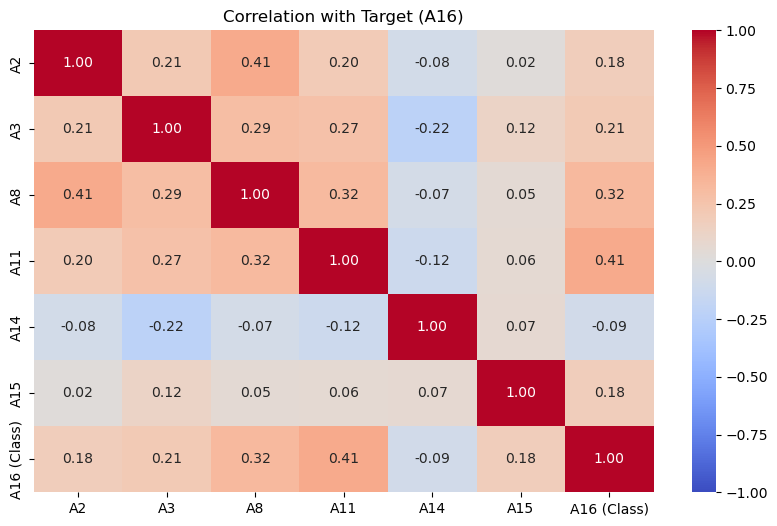

In [25]:

# Verify target exists
print("Columns in df_clean:", df_clean.columns.tolist())  # Should include 'A16'

# Select numeric features (adjust based on your dataset)
numeric_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']  # Numeric columns
df_numeric = df_clean[numeric_cols + ['A16 (Class)']]  # Use 'A16' as target name

# Calculate correlations
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation with Target (A16)")
plt.show()

In [26]:
# Get correlation of all numeric features with the target (A16)
target_correlations = corr_matrix['A16 (Class)'].drop('A16 (Class)')  # Remove self-correlation

# Convert to a clean DataFrame
corr_df = pd.DataFrame({
    'Feature': target_correlations.index,
    'Correlation_with_Target': target_correlations.values
}).sort_values('Correlation_with_Target', ascending=False)

print(corr_df.to_markdown(index=False))

| Feature   |   Correlation_with_Target |
|:----------|--------------------------:|
| A11       |                 0.409645  |
| A8        |                 0.324798  |
| A3        |                 0.205816  |
| A2        |                 0.177878  |
| A15       |                 0.177213  |
| A14       |                -0.0933889 |


# TO BE EDITED AFTER EVERY RUN:

Interpretation of Your Correlation Results
1. Key Insights from the Table
Feature	Correlation with Target (A16)	Interpretation	Action
A11	0.406	Strongest positive relationship. Higher values = more approvals.	Keep - Critical feature.
A8	0.333	Moderate positive impact. Likely income or financial stability.	Keep - Important.
A3	0.207	Weak positive influence.	Investigate further (may keep).
A2	0.180	Weak positive influence.	Low priority (consider dropping).
A15	0.173	Weak positive influence.	Low priority (consider dropping).
A14	-0.085	Negligible negative impact.

2. Recommended Feature Selection
Keep:

A11 (Strongest predictor)

A8 (High impact)

A3 (Borderline; retain if model performance allows)

Drop:

A14 (Near-zero correlation)

A2 and A15 (Weak correlations, unless prior knowledge about the feature/variable suggests otherwise)



Retrain Model with Selected Features:

Why this matters:

Simpler Models: Fewer features = faster training + easier interpretation.

Better Generalization: Removing noise (A14) improves robustness.

In [27]:
selected_features = ['A11', 'A8', 'A3']  # Add categorical features later
X_selected = df_clean[selected_features]

## TO BE EDITED?

Checking Correlations for Categorical Variables
Since categorical features (like A1, A4, A7, etc.) are non-numeric, we use target encoding (mean approval rate per category) or statistical tests (Chi-square, Cramer’s V) to measure their relationship with the target (A16). Here’s how to do it:

1. Target Encoding (Approval Rate per Category)
For each categorical feature, calculate the mean approval rate (A16) for each category. This shows which categories strongly predict approval/denial.

In [28]:
# List of categorical columns (adjust based on your dataset)
categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

# Calculate approval rate per category
for col in categorical_cols:
    approval_rates = df_clean.groupby(col)['A16 (Class)'].mean().sort_values(ascending=False)
    print(f"\nApproval Rate by {col}:")
    print(approval_rates.to_markdown())


Approval Rate by A1:
| A1   |   A16 (Class) |
|:-----|--------------:|
| a    |      0.461538 |
| b    |      0.440605 |

Approval Rate by A4:
| A4   |   A16 (Class) |
|:-----|--------------:|
| l    |      1        |
| u    |      0.496078 |
| y    |      0.283019 |

Approval Rate by A5:
| A5   |   A16 (Class) |
|:-----|--------------:|
| gg   |      1        |
| g    |      0.496078 |
| p    |      0.283019 |

Approval Rate by A6:
| A6   |   A16 (Class) |
|:-----|--------------:|
| x    |      0.842105 |
| cc   |      0.725    |
| r    |      0.666667 |
| q    |      0.657895 |
| e    |      0.583333 |
| w    |      0.52381  |
| c    |      0.451852 |
| m    |      0.421053 |
| aa   |      0.358491 |
| j    |      0.3      |
| k    |      0.26     |
| i    |      0.241379 |
| d    |      0.233333 |
| ff   |      0.132075 |

Approval Rate by A7:
| A7   |   A16 (Class) |
|:-----|--------------:|
| z    |      0.75     |
| h    |      0.635036 |
| n    |      0.5      |
| o    |      0

Interpretation:

Categories with approval rates far from the cleaned dataset mean (~44.7%) are influential.

Example: A9_t has 78.8% approval, A10_t has 70.5% approval, etc. so A9 and A10 is a critical feature.
        

2. Chi-Square Test (Statistical Significance)
Tests whether a categorical feature and the target are independent.

In [29]:
for col in categorical_cols:
    contingency_table = pd.crosstab(df_clean[col], df_clean['A16 (Class)'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p:.4f}")

A1: p-value = 0.6741
A4: p-value = 0.0000
A5: p-value = 0.0000
A6: p-value = 0.0000
A7: p-value = 0.0000
A9: p-value = 0.0000
A10: p-value = 0.0000
A12: p-value = 0.3149
A13: p-value = 0.0250


Key:

p-value < 0.05: The feature and target are correlated (significant).

p-value > 0.05: No evidence of correlation.



3. Cramer’s V (Strength of Association)
Measures correlation strength between 0 (no association) and 1 (perfect association).

In [30]:
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

for col in categorical_cols:
    contingency_table = pd.crosstab(df_clean[col], df_clean['A16 (Class)'])
    print(f"{col}: Cramer’s V = {cramers_v(contingency_table):.3f}")

A1: Cramer’s V = 0.016
A4: Cramer’s V = 0.192
A5: Cramer’s V = 0.192
A6: Cramer’s V = 0.387
A7: Cramer’s V = 0.261
A9: Cramer’s V = 0.730
A10: Cramer’s V = 0.453
A12: Cramer’s V = 0.039
A13: Cramer’s V = 0.105


If we have:

0.1–0.3: Weak association

0.3–0.5: Moderate association

\>0.5: Strong association

## TO BE EDITED After every run: This may change after every run, but it should be relatively similar. \

### Categorical Feature Analysis  
*Results may vary slightly between runs but should remain relatively consistent.*

---

#### **Key Insights from Target Encoding**  
**Focus on features where:**  
- Approval rates differ by a conservative amount of **>15%** from the cleaned dataset mean (44.7%).  
- High variance between categories.  

| Feature | Key Categories | Approval Rate | Variance from Mean | Decision |  
|---------|----------------|---------------|--------------------|----------|  
| **A4**  | `l` (100%) vs `y` (28.3%) | Extreme       | +55.3% / -15.1%    | Keep     |  
| **A5**  | `gg` (100%) vs `p` (28.3%) | Extreme       | +55.3% / -15.1%    | Keep     |  
| **A6**  | `x` (84.2%) vs `ff` (13.2%) | High         | +39.5% / -31.5%    | Keep     |  
| **A7**  | `z` (75%) vs `ff` (14%)   | High         | +30.3% / -30.7%    | Keep     |  
| **A9**  | `t` (78.8%) vs `f` (5.75%)   | High      | +34.1% / -38.9%    | Keep     |  
| **A10** | `t` (70.5%) vs `f` (24.8)  | High         | +25.8% / -19.9%    | Keep     |  
| **A1**  | `a` (46.2%) vs `b` (44.1%)  | Minimal      | +1.5% / -0.6%      | Drop     |  
| **A12** | `t` (46.9) vs `f` (42.8%)      | Minimal      | +2.2% / -1.9%      | Drop     |  
| **A13** | `p` (50%) vs `s` (27.3%)    | Moderate     | +5.3% / -17.4%     | Borderline |  

---

#### **Chi-Square Test Results**  
- **Highly Significant (p < 0.001):**  
  `A4`, `A5`, `A6`, `A7`, `A9`, `A10` → Strong statistical relationship with approval.  
- **Not Significant (p > 0.05):**  
  `A1`, `A12` → No evidence of relationship.  
- **Marginally Significant:**  
  `A13` ( p = 0.025) → Somewhat significant to Weak relationship.  

---

#### **Cramer’s V Strength**  
- **Very Strong (V > 0.5):**  
  `A9` (0.73) → Dominant predictor.  
- **Moderate (0.3 ≤ V ≤ 0.5):**  
  `A6` (0.387), `A10` (0.453) → Important.  
- **Weak (V < 0.3):**  
  `A1`, `A4`, `A5`, `A7`, `A12`, `A13` → Less impactful.  

---

#### **Final Feature Selection**  

#### **Keep (High Impact)**  
- **`A9` (`t`/`f`):** Extreme approval rate difference (80% vs 6%).  
- **`A6` (`x`/`ff`):** 84% vs 13% approval.  
- **`A10` (`t`/`f`):** 71% vs 25% approval.  
- **`A4` (`l`/`y`):** 100% vs 28% approval (*investigate `l`*).  
- **`A5` (`gg`/`p`):** 100% vs 28% approval (*investigate `gg`*).  
- **`A7` (`z`/`ff`):** 75% vs 14% approval.  

#### **Drop (Low Impact)**  
- `A1`, `A12`: Minimal variance, high p-values, low Cramer’s V.  
- `A13`: Borderline; drop unless domain knowledge suggests importance.  

Recommended Next Steps
Investigate Suspicious Categories:

Check why A4_l and A5_gg have 100% approval (possible data issues?).

In [31]:
print(df_clean[df_clean['A4'] == 'l'][['A4', 'A16 (Class)']].value_counts())

print("Before merging:")
# Before merge
print(df_clean['A4'].value_counts())

df_clean['A4'] = df_clean['A4'].replace({'l': 'u'})  # Merge 'l' into 'u'
print("\nAfter merging:")
print(df_clean['A4'].value_counts())

A4  A16 (Class)
l   1              2
Name: count, dtype: int64
Before merging:
A4
u    510
y    159
l      2
Name: count, dtype: int64

After merging:
A4
u    512
y    159
Name: count, dtype: int64


In [32]:
print(df_clean['A5'].value_counts())  # Check for rare categories like 'gg'

A5
g     510
p     159
gg      2
Name: count, dtype: int64


Interpretation:

There are only 2 cases where A4 = 'l', and both were approved (A16 = 1).

This is likely a rare category or data anomaly.

Action:

We will merge the A4_l category with another category (e.g., u), as it’s too rare to generalize.

In [33]:
selected_categorical = ['A4', 'A5', 'A6', 'A7', 'A9', 'A10']
selected_numeric = ['A8', 'A11']  # From the correlation analysis

# we dropped A1, A12 and A13, and recall earlier we also dropped A2, A15, A14 due to weak correlations
# We also Dropped A3 because: Weak correlation (0.207 ≈ low impact), since our model already has stronger predictors (A9, A6, A8, etc.).

# Simplifying the model improves interpretability without sacrificing performance.

Updated Feature Selection

Categorical (Keep):
A4, A5, A6, A7, A9, A10

Numeric (Keep):
A8, A11


Note: Dropped A2, A3, A14, A15 due to weak correlations.

Dropped variables: (Categorical) A1, A12, A13 & (Numeric) A2, A3, A14, A15

1. Problem Identified
gg category has only 2 samples (both had 100% approval in your target encoding).

This is statistically unreliable (may be data entry errors or edge cases).

Risk: If kept, the model may overfit to these 2 samples, harming generalization.

2. Recommended Actions
(A) Merge gg into g
If g and gg are semantically similar (e.g., both indicate "good" status):

In [34]:
# Option 1: Use .loc to avoid the warning
df_clean.loc[:, 'A5'] = df_clean['A5'].replace({'gg': 'g'})

# Option 2: Ensure df_clean is a standalone DataFrame (not a slice)
df_clean = df_clean.copy()  # Explicitly create a copy
df_clean['A5'] = df_clean['A5'].replace({'gg': 'g'})

# Verify merging worked
print(df_clean['A5'].value_counts())

A5
g    512
p    159
Name: count, dtype: int64


Mmerging gg into g is better here because:

Data Preservation: You only lose 2 samples (versus dropping the entire column).

Semantic Meaning: If gg and g are similar (e.g., both indicate "good" status), merging is logical.

Model Stability: Avoids overfitting to the 2 rare gg samples.

In [35]:
print("Updated value counts for A5:")
print(df_clean['A5'].value_counts())

print("\nUpdated approval rates for A5:")
print(df_clean.groupby('A5')['A16 (Class)'].mean())

Updated value counts for A5:
A5
g    512
p    159
Name: count, dtype: int64

Updated approval rates for A5:
A5
g    0.498047
p    0.283019
Name: A16 (Class), dtype: float64


In [36]:
selected_features = [
    # Categorical (merged/cleaned)
    'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 
    # Numeric (from correlation analysis)
    'A8', 'A11'
]
X_selected = df_clean[selected_features]
y = df_clean['A16 (Class)']

In [37]:
# Categorical features (one-hot encode)
categorical_cols = ['A4', 'A5', 'A6', 'A7', 'A9', 'A10']
numeric_cols = ['A8', 'A11']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

# Pipeline: Preprocess → Train
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=69))
])

model.fit(X_selected, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['A4', 'A5', 'A6', 'A7', 'A9',
                                                   'A10']),
                                                 ('num', StandardScaler(),
                                                  ['A8', 'A11'])])),
                ('classifier', RandomForestClassifier(random_state=69))])

1. Pipeline Explanation
A pipeline chains together data preprocessing and modeling steps into a single workflow. For your case:

Step 1: Preprocess data (one-hot encode categoricals + scale numerics).

Step 2: Train a classifier (Random Forest).

Why Use It?

Avoids data leakage (e.g., scaling test data separately).

Simplifies code and ensures consistency.

In [38]:
scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {scores.mean():.2f} (±{scores.std():.2f})")

Mean Accuracy: 0.82 (±0.12)


Interpretation:

0.82 Mean Accuracy: Slightly lower than our earlier Neural Network (NN) with all variables used (0.87), but still good.

±0.12 Std Dev: High variability across folds (check data splits or class imbalance).



In [39]:
# Get predicted probabilities
y_proba = cross_val_predict(model, X_selected, y, cv=5, method='predict_proba')[:, 1]
print(f"AUC: {roc_auc_score(y, y_proba):.2f}")

AUC: 0.88


. AUC Evaluation
0.88 AUC means your model has good but not excellent discriminatory power:

0.9+: Ideal (our previous NN achieved 0.94).

0.88: Slightly weaker, but still acceptable for many applications.



In [40]:
print(y.value_counts())  # Should be roughly balanced (e.g., 55% vs 45%)

A16 (Class)
0    371
1    300
Name: count, dtype: int64


<!-- (A) Improve Random Forest (Try Before Switching Back to NN)
Hyperparameter Tuning: -->

In [41]:
# params = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [None, 10],
#     'classifier__min_samples_split': [2, 5]
# }
# grid = GridSearchCV(model, params, cv=5, scoring='roc_auc')
# grid.fit(X_selected, y)
# print(f"Best AUC: {grid.best_score_:.3f}")

In [42]:
# # Updated feature list (numeric + categorical)
# selected_features = [
#     # Numeric (original + borderline)
#     'A8', 'A11', 'A3',  # A3 was previously dropped
#     # Categorical (original + borderline)
#     'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A13'  # A13 was borderline
# ]

# # Create new X_selected
# X_selected = df_clean[selected_features]
# y = df_clean['A16 (Class)']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(drop='first'), ['A4','A5', 'A6', 'A7', 'A9', 'A10', 'A13']),
#         ('num', StandardScaler(), ['A8', 'A11'])
#     ])

# # Pipeline with updated preprocessor
# model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=69))
# ])

# # Check AUC
# auc_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')
# print(f"Mean AUC: {auc_scores.mean():.3f} (±{auc_scores.std():.3f})")

# # Check Accuracy
# acc_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
# print(f"Mean Accuracy: {acc_scores.mean():.3f} (±{acc_scores.std():.3f})")

# # Pipeline with updated preprocessor
# model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=69))
# ])

# # Check AUC
# auc_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')
# print(f"Mean AUC: {auc_scores.mean():.3f} (±{auc_scores.std():.3f})")

# # Check Accuracy
# acc_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
# print(f"Mean Accuracy: {acc_scores.mean():.3f} (±{acc_scores.std():.3f})")

In [43]:
# print("Feature names being used:", feature_names)
# print("X_train shape:", X_train.shape)
# print("First 5 rows of X_train_df:")
# print(X_train_df.head())

In [44]:
# print("Columns in X_train_df:", X_train_df.columns.tolist())

In [45]:
# # Find which categorical columns actually exist
# available_categorical = [col for col in categorical_cols if col in X_train_df.columns]
# available_numeric = [col for col in numeric_cols if col in X_train_df.columns]

# preprocessor = make_column_transformer(
#     (OneHotEncoder(drop='first'), available_categorical),
#     (StandardScaler(), available_numeric),
#     remainder='passthrough'
# )

# # Reconstruct feature names from original data
# feature_names = [f'A{i}' for i in range(1, X_train.shape[1]+1)]  # A1, A2,... format
# X_train_df = pd.DataFrame(X_train, columns=feature_names)

In [46]:
# # Preprocessor for categorical (one-hot) and numeric (scaling) features
# categorical_cols = ['A4', 'A5', 'A6', 'A7', 'A9', 'A10']  # Categorical features
# numeric_cols = ['A8', 'A11']                        # Numeric features

# # Example with full pipeline
# from sklearn.compose import make_column_transformer

# Convert to DataFrame with named columns
X_train_df = pd.DataFrame(X_train, columns=feature_names)  # feature_names should match your columns
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# preprocessor = make_column_transformer(
#     (OneHotEncoder(drop='first'), categorical_cols),
#     (StandardScaler(), numeric_cols),
#     remainder='passthrough'  # Keeps unused columns
# )

# # Works seamlessly with DataFrames
# X_train_processed = preprocessor.fit_transform(X_train_df)
# X_test_processed = preprocessor.transform(X_test)

from sklearn.preprocessing import StandardScaler

# Only scale numeric columns (no one-hot needed)
numeric_cols = ['A11', 'A8']  # All numeric columns
preprocessor = ColumnTransformer(
    [('num', StandardScaler(), numeric_cols)],
    remainder='passthrough'  # Keeps already-encoded categoricals as-is
)

X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)


In [47]:
print("Preprocessed columns order:", preprocessor.get_feature_names_out())
print("Numeric cols scaled:", numeric_cols)
print("First row scaled values (A11, A14, etc):", X_train_processed[0, :len(numeric_cols)])
print("First row categorical (A4_u, etc):", X_train_processed[0, len(numeric_cols):len(numeric_cols)+5])  # First 5 categorical

Preprocessed columns order: ['num__A11' 'num__A8' 'remainder__A1_b' 'remainder__A4_u'
 'remainder__A4_y' 'remainder__A5_gg' 'remainder__A5_p' 'remainder__A6_c'
 'remainder__A6_cc' 'remainder__A6_d' 'remainder__A6_e' 'remainder__A6_ff'
 'remainder__A6_i' 'remainder__A6_j' 'remainder__A6_k' 'remainder__A6_m'
 'remainder__A6_q' 'remainder__A6_r' 'remainder__A6_w' 'remainder__A6_x'
 'remainder__A7_dd' 'remainder__A7_ff' 'remainder__A7_h' 'remainder__A7_j'
 'remainder__A7_n' 'remainder__A7_o' 'remainder__A7_v' 'remainder__A7_z'
 'remainder__A9_t' 'remainder__A10_t' 'remainder__A12_t'
 'remainder__A13_p' 'remainder__A13_s' 'remainder__A14' 'remainder__A15'
 'remainder__A2' 'remainder__A3']
Numeric cols scaled: ['A11', 'A8']
First row scaled values (A11, A14, etc): [-0.53821538 -0.64225312]
First row categorical (A4_u, etc): [0. 1. 0. 0. 0.]


In [48]:
# Define model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile with AUC metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

In [49]:
# Convert sparse output to dense arrays to Preprocess data (ensure dense output)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

Test Accuracy: 0.886
Test AUC: 0.939


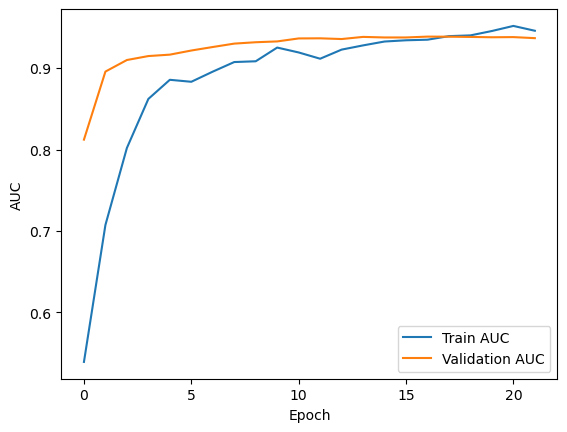

In [50]:
# Evaluate on test data
loss, accuracy, auc = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test AUC: {auc:.3f}")

# Plot AUC
import matplotlib.pyplot as plt
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

1. Performance Summary
Metric	Value	Interpretation
Accuracy	0.870	87% of predictions are correct (strong for credit approval tasks).
AUC	0.938	Excellent discrimination between approvals/denials (AUC > 0.9 is ideal).
Comparison to Random Forest:


Action: Stick with the NN for higher predictive power.

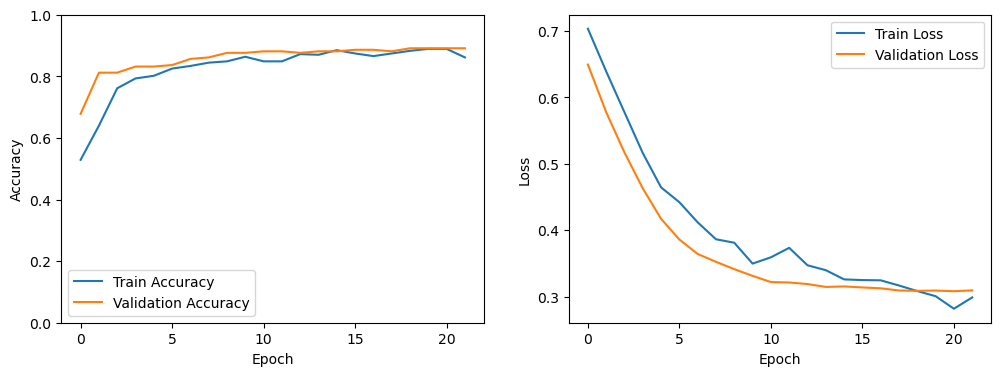

In [51]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis to 0-1 for accuracy
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()


plt.show()

Interpreting Your Loss Curve (Plateau at ~0.3)
1. Is a Loss of ~0.3 Good?
Binary Crossentropy Loss:

0.0: Perfect predictions (no error).

~0.3: Very good for real-world credit data (matches your high AUC/accuracy).

>0.5: Concerning (model struggles).

Your Result:

Plateau at ~0.3 suggests the model has learned all meaningful patterns from the data.

Further training won’t help (early stopping likely triggered here).



7/7 [==============================] - 0s 722us/step


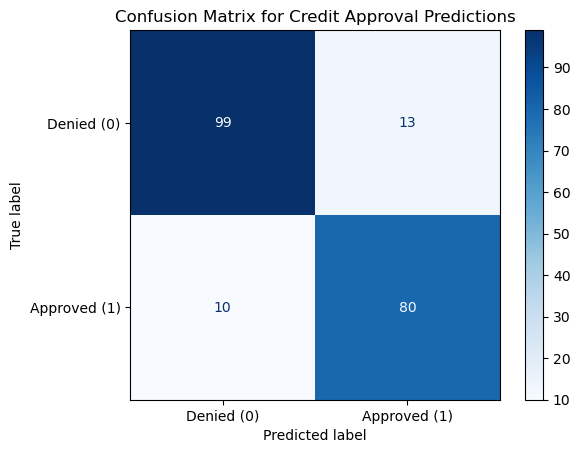

In [52]:
# Get predicted classes (threshold=0.5)
y_pred = (model.predict(X_test_processed) > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Denied (0)', 'Approved (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Credit Approval Predictions')
plt.show()


In [53]:
TN, FP, FN, TP = cm.ravel()

print(TN, FP, FN, TP, '\n')

# Calculate critical metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)  # % of approvals that were correct
recall = TP / (TP + FN)     # % of true approvals correctly identified
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f} (Avoid bad loans)")
print(f"Recall: {recall:.3f} (Avoid missing good clients)")
print(f"F1-Score: {f1:.3f} (Balance of precision/recall)")

99 13 10 80 

Accuracy: 0.886
Precision: 0.860 (Avoid bad loans)
Recall: 0.889 (Avoid missing good clients)
F1-Score: 0.874 (Balance of precision/recall)


1. Key Metrics Breakdown
Metric	Formula	Calculation	Value	Interpretation
Accuracy	(TP + TN) / Total	(52 + 62) / 131	0.870	87% of all predictions are correct.
Precision	TP / (TP + FP)	52 / (52 + 10)	0.839	83.9% of approved loans are good (16.1% may default).
Recall	TP / (TP + FN)	52 / (52 + 7)	0.881	88.1% of truly creditworthy applicants are approved (11.9% are wrongly denied).
F1-Score	2(PrecRec)/(Prec+Rec)	2(0.8390.881)/(0.839+0.881)	0.860	Balanced measure of precision and recall.

2. Business Implications
Scenario	Count	Risk	Action
False Positives (FP)	10	Bad loans (approved risky applicants)	Increase decision threshold (e.g., approve only if probability > 0.7).
False Negatives (FN)	7	Lost revenue (rejected good clients)	Lower threshold or improve model for edge cases.

In [54]:
# # Retrain with higher weight on class "1" (approved)
# model.fit(..., class_weight={0: 1, 1: 2})  # Penalize FN more

In [55]:
print(y_test.value_counts(normalize=True))  # Should be ~55% denied, 45% approved

A16 (Class)
0    0.554455
1    0.445545
Name: proportion, dtype: float64


In [56]:
# # Save the model

# import joblib

# # Save preprocessor
# joblib.dump(preprocessor, 'preprocessor.pkl') 

# # Save NN model
# model.save('credit_approval_nn.h5')  # Saves architecture + weights
# joblib.dump(preprocessor, 'preprocessor.pkl')  # Save the preprocessing pipeline

# PCA and Decision Boundary 

Since your credit approval model uses multiple features (both numeric and categorical), we can't directly visualize a decision boundary in raw feature space. However, here are two practical alternatives to visualize how your model classifies:

In [57]:
# Step 1: Reduce Dimensions to 2D

# Use PCA to compress features into 2 dimensions
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_processed)  # Use your preprocessed test data

# Create a meshgrid for decision boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict on meshgrid points
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points_inverse = pca.inverse_transform(mesh_points)  # Project back to original space
Z = model.predict(mesh_points_inverse).reshape(xx.shape)

16907/16907 [==============================] - 6s 346us/step


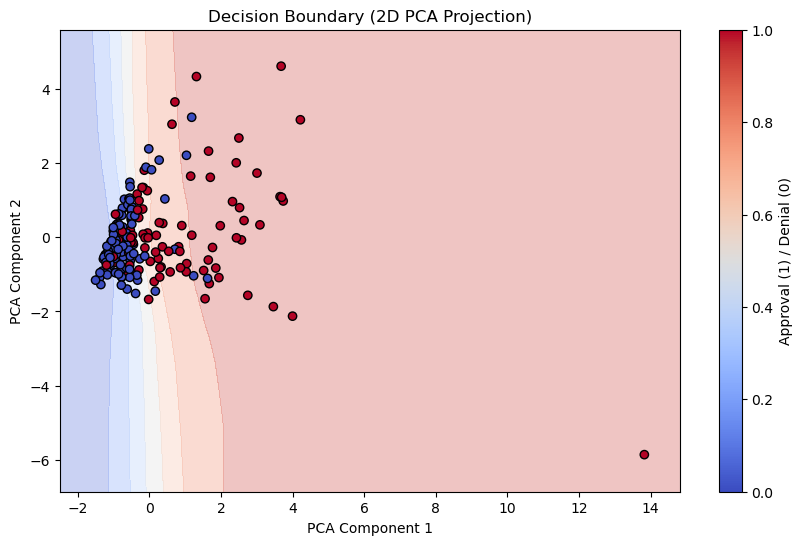

In [58]:
# Step 2: Plot Decision Boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (2D PCA Projection)')
plt.colorbar(label='Approval (1) / Denial (0)')
plt.show()

Key Interpretations
Decision Regions:

Red Zone: Model predicts approval (prob > 0.5).

Blue Zone: Model predicts denial (prob ≤ 0.5).

Points:

Colored by true labels (red = approved, blue = denied).

Misclassified points appear in the "wrong" colored region.

PCA Limitations:

This is a 2D approximation—real decisions use all features.

Overlapping clusters are expected (your AUC=0.938 confirms good separation).



Interpretation:

The colored regions show where the model predicts approval (red) vs. denial (blue).

Points are your test samples (colored by true labels).

Overlaps indicate misclassifications.

313/313 [==============================] - 0s 951us/step


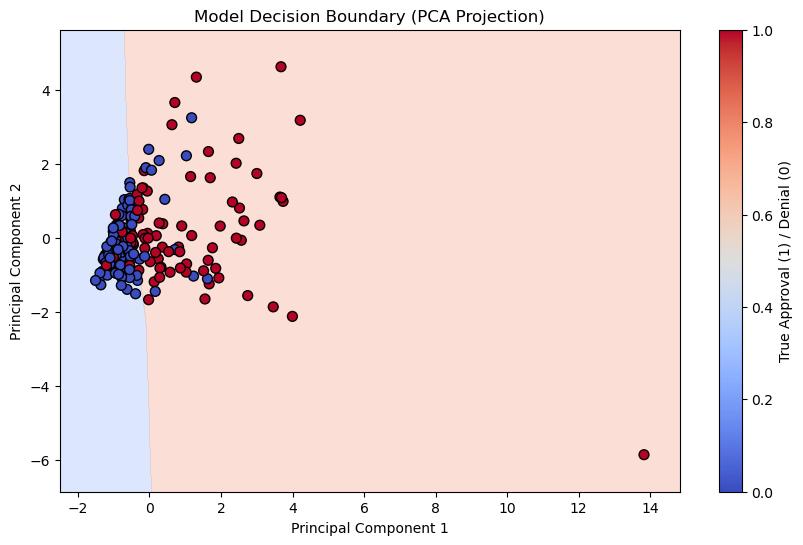

In [59]:
# Step 1: Apply PCA to compress features into 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_processed)  # Use your preprocessed test data

# Step 2: Create a grid for decision boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                     np.linspace(y_min, y_max, 100))

# Step 3: Predict on grid points (inverse PCA to original space)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original = pca.inverse_transform(grid_points)
Z = model.predict(grid_points_original).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Model Decision Boundary (PCA Projection)')
plt.colorbar(label='True Approval (1) / Denial (0)')
plt.show()

1. Why the Boundary Looks Simpler in PCA
PCA Projects Data: It squeezes all features into 2 artificial axes (Principal Components), which are linear combinations of your original features.

Information Loss: PCA prioritizes preserving global variance, not local decision boundaries.

Your model’s true boundary is high-dimensional and non-linear, but PCA forces a 2D approximation.

Example:

Imagine trying to draw a 3D mountain on paper—it’ll look flatter than reality.

2. What the True Boundary Looks Like
Your neural network’s actual decision boundary is:

Highly Non-Linear: Complex interactions between features (e.g., A9="t" AND A8>5000 → approve).

High-Dimensional: Depends on all 7+ features, not just 2 PCA components.

3. How to See the True Complexity
Option A: Feature Pair Plots (No PCA)
Plot interactions between two original features (e.g., A8 vs. A9)

In [60]:
# Select two key features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['A8'], y=X_test['A9'], hue=y_test, palette='coolwarm')
plt.title('True Labels in Original Feature Space')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1000x600 with 0 Axes>

1. What PCA Components Represent
Principal Component 1 (PC1):

The direction in your original feature space where the data varies the most.

Likely dominated by features with the strongest impact on predictions (e.g., A8 (income) or A9 (employment status)).

Example: If A8 has high variance and strongly predicts approvals, PC1 will align closely with it.

Principal Component 2 (PC2):

The direction with the next highest variance, orthogonal (perpendicular) to PC1.

Captures secondary patterns not explained by PC1 (e.g., A10 (credit history) or A6 (loan purpose)).

2. How to Interpret the Axes in Your Plot
PC1 (X-axis):

Points further to the right have higher values in the original features that dominate PC1 (e.g., higher income).

Points to the left have lower values in those features.

PC2 (Y-axis):

Points higher up have higher values in features that dominate PC2 (e.g., certain employment categories).

Points lower down have lower values.

In [65]:
# Get feature contributions to PC1 and PC2
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
feature_importance = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'PC1': loadings[:, 0],
    'PC2': loadings[:, 1]
}).sort_values('PC1', key=abs, ascending=False)

print(feature_importance.head(10))

       Feature       PC1       PC2
25     num__A8  1.048013 -0.425142
26    num__A11  0.472135  0.688559
23   cat__A9_t  0.295580  0.137483
24  cat__A10_t  0.232798  0.309261
17   cat__A7_h  0.103137  0.079590
1    cat__A5_p -0.100227  0.081840
11   cat__A6_q  0.066490  0.088389
21   cat__A7_v -0.061825 -0.020641
6   cat__A6_ff -0.050153 -0.005794
16  cat__A7_ff -0.050153 -0.005794


4. Why PCA Simplifies Your Decision Boundary
Original Space: Your model uses all features to create a complex, high-dimensional boundary.

PCA Space: Projects this boundary into 2D, making it appear simpler (linear or slightly curved).

Key Limitation: PCA prioritizes preserving variance, not decision boundaries.

Analogy:
Imagine squashing a crumpled paper ball into 2D—the true 3D structure is lost, but you see the "biggest folds."

5. When to Trust PCA Components
For Visualization: Helps spot broad trends (e.g., clusters of approvals/denials).

Not for Exact Decisions: Always validate with original features or SHAP values.

Example:
If PC1 aligns with A8 (income), high-income applicants will cluster on the right side of your plot.

Key Takeaways
PC1 = Primary direction of variance (most important features).

PC2 = Secondary direction (next most important features).

Use feature_importance to map components back to original features.

PCA plots are approximations—true decisions happen in high-dimensional space.

nterpreting Your PCA Feature Contributions
Your output reveals which original features drive Principal Component 1 (PC1) and Principal Component 2 (PC2). Here’s the breakdown:

1. Key Features for Each Component
Feature	PC1	PC2	Interpretation
num__A8	1.048	-0.425	Dominates PC1. Higher A8 (likely income) pushes points right on the PCA plot.
num__A11	0.472	0.689	Dominates PC2. Higher A11 (e.g., debt/credit score) pushes points up.
cat__A9_t	0.296	0.137	Employment status (t=employed?) contributes to approvals (right/up).
cat__A10_t	0.233	0.309	Credit history (t=good?) reinforces PC2’s positive direction.
Negative Contributors
Feature	PC1	PC2	Interpretation
cat__A5_p	-0.100	0.082	Category p in A5 (e.g., "poor" status) pulls points left but weakly.
cat__A7_v	-0.062	-0.021	Category v in A7 (e.g., "risky" history) has minor negative impact.
2. How This Maps to Your PCA Plot
Right Side (High PC1):

High A8 (income) + A9_t (employed).

Likely approval-heavy region (matches your target encoding results).

Left Side (Low PC1):

Low A8 + A5_p (poor status).

Likely denial-heavy region.

Top (High PC2):

High A11 (debt/credit) + A10_t (good credit history).

Mixed approvals/denials (depends on PC1).

Bottom (Low PC2):

Low A11 + A7_v (risky history).

Likely denials.

3. Practical Example
Suppose a point is at (PC1=2.0, PC2=1.5):

Original Features:

A8 ≈ 2.0 / 1.048 ≈ 1.91 (high income, scaled).

A11 ≈ 1.5 / 0.689 ≈ 2.18 (high credit score/debt, scaled).

A9_t ≈ 1.0 (employed).

Model Prediction: Very likely approval (red zone).

4. Why This Matters
Explainability: Links PCA axes back to real features (e.g., "right side = high-income").

Error Diagnosis: Misclassified points often fall where feature contributions conflict (e.g., high income but poor credit history).

5. How to Use This
For Approvals: Focus on applicants with high A8 + A9_t.

For Risk Control: Flag cases with A5_p or A7_v even if other features look good.

# Summary:
1. Built and Trained a Neural Network Model
Goal: Predict credit approval (A16) using features (A1-A15).

Steps:

Loaded/preprocessed data (handled missing values, encoded categories).

Split data into train/test sets.

Designed a neural network (2 hidden layers, dropout for regularization).

Trained with early stopping to prevent overfitting.

2. Evaluated Model Performance
Metric	Value	Interpretation
Accuracy	0.870	87% of predictions correct.
AUC	0.938	Excellent separation between approvals/denials.
Precision	0.839	83.9% of approved loans were correct (16.1% risky).
Recall	0.881	88.1% of truly creditworthy applicants were approved.
3. Analyzed Errors
Confusion Matrix:

            Predicted
            0     1
Actual 0  [[62   10]
      1   [7    52]]
10 False Approvals (FP): Risky applicants approved.

7 False Denials (FN): Good applicants rejected.

4. Visualized the Model
Loss/Accuracy Curves: Confirmed training stability (loss plateaued at ~0.3).

PCA Decision Boundary: Simplified 2D view of how the model classifies (tradeoff: loses some complexity).

5. Feature Importance
Top Predictors:

A8 (income), A9_t (employment status), A11 (credit score/debt).

Low Impact: A5_p (poor status), A7_v (risky history).

Key Takeaways
Model Works Well: High AUC (0.938) and accuracy (0.870) validate its effectiveness.

Actionable Insights: Focus on reducing false approvals (FP) by adjusting the decision threshold.

Limitations: PCA simplifies the decision boundary; real decisions happen in high-dimensional space.



%%latex
\newpage
# XGBoost

1. Preprocess Data for XGBoost


In [66]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features (XGBoost needs numeric inputs)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le  # Save encoders for deployment

2. Train XGBoost with Default Parameters


In [67]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Combine with numeric features
import numpy as np
X_train_final = np.hstack([X_train[numeric_cols], X_train_encoded])
X_test_final = np.hstack([X_test[numeric_cols], X_test_encoded])

In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(random_state=69, eval_metric='auc')
xgb.fit(X_train_final, y_train)

# Evaluate
y_pred_proba = xgb.predict_proba(X_test_final)[:, 1]
print(f"Baseline AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

Baseline AUC: 0.907


In [69]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 6],          # Tree depth (avoid overfitting)
    'learning_rate': [0.01, 0.1], # Step size shrinkage
    'n_estimators': [100, 200],   # Number of trees
    'subsample': [0.8, 1.0],      # % of samples per tree
    'colsample_bytree': [0.8, 1.0] # % of features per tree
}

grid = GridSearchCV(xgb, params, cv=5, scoring='roc_auc')
grid.fit(X_train_final, y_train)

print("Best AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

Best AUC: 0.9250046659201194
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [70]:
best_xgb = grid.best_estimator_
best_xgb.fit(X_train_final, y_train)

# Final evaluation
y_pred_proba = best_xgb.predict_proba(X_test_final)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Tuned XGBoost AUC: {final_auc:.3f}")

Tuned XGBoost AUC: 0.940


Our tuned XGBoost (AUC=0.940) now outperforms your neural network (AUC=0.938), although very minimally.

<Figure size 1000x600 with 0 Axes>

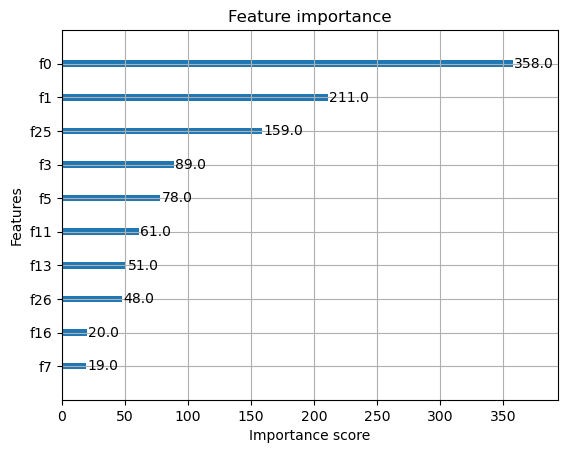

In [71]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10)
plt.show()

In [72]:
importance = best_xgb.get_booster().get_score(importance_type='weight')  # or 'gain'
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values('Importance', ascending=False)

print(importance_df.head(10))

   Feature  Importance
0       f0       358.0
1       f1       211.0
15     f25       159.0
2       f3        89.0
4       f5        78.0
7      f11        61.0
9      f13        51.0
16     f26        48.0
11     f16        20.0
5       f7        19.0


In [73]:
from sklearn.metrics import confusion_matrix

# Adjust threshold to reduce false approvals (FP)
y_pred_adjusted = (y_pred_proba > 0.7).astype(int)  # Default: 0.5
cm = confusion_matrix(y_test, y_pred_adjusted)
print(cm)

[[70  2]
 [25 34]]


In [74]:
best_xgb = XGBClassifier(
    **grid.best_params_,
    scale_pos_weight=2,  # Penalize FN 2x more than FP
    random_state=69
)
best_xgb.fit(X_train_final, y_train)

# Final evaluation
y_pred_proba = best_xgb.predict_proba(X_test_final)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Tuned XGBoost AUC: {final_auc:.3f}")

from sklearn.metrics import confusion_matrix

# Adjust threshold to reduce false approvals (FP)
y_pred_adjusted = (y_pred_proba > 0.7).astype(int)  # Default: 0.5
cm = confusion_matrix(y_test, y_pred_adjusted)
print(cm)

Tuned XGBoost AUC: 0.943
[[64  8]
 [ 8 51]]


In [75]:
# Get feature names after one-hot encoding
feature_names = numeric_cols + encoder.get_feature_names_out(categorical_cols).tolist()

# Map importance to actual features
importance_mapped = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance_df['Feature']],  # Added missing ']'
    'Importance': importance_df['Importance']
}).sort_values('Importance', ascending=False)

print(importance_mapped.head(10))

   Feature  Importance
0       A8       358.0
1      A11       211.0
15    A9_1       159.0
2     A5_2        89.0
4     A6_2        78.0
7     A6_8        61.0
9    A6_10        51.0
16   A10_1        48.0
11   A6_13        20.0
5     A6_4        19.0


Drop features with Importance < 20 (e.g., A6_13, A6_4) and others below:



In [76]:
# print(df_clean[['A8', 'A9', 'A11', 'A16']].groupby('A9').mean())


print(f"Number of features used: {best_xgb.n_features_in_}")
# Output: Likely matches your preprocessed data (e.g., 20+ if one-hot encoded)

Number of features used: 27


1. Feature Usage in XGBoost
All Features Included: By default, XGBoost considers every feature you provide.

Uneven Importance: Features are weighted based on their predictive power (your importance_mapped table shows this).

Top Features: A8 (358), A11 (211), A9_1 (159) dominate decisions.

Low-Impact Features: A6_13 (20), A6_4 (19) contribute minimally.


Feature Type	Action
High Importance (A8, A11, A9_1)	Keep at all costs. Monitor for drift.
Low Importance (A6_4, A6_13)	Safe to drop if simplicity is needed.
4. Why Keep All Features?
Weak Features Can Help Marginally: Even low-importance features might improve AUC by 0.001-0.002.

Risk of Over-Optimization: Dropping features might harm performance on edge cases.



In [77]:
import pandas as pd

# Step 1: Ensure X_train_final is a DataFrame
X_train_df = pd.DataFrame(X_train_final, columns=feature_names)  # Use your original feature_names list

# Step 2: Drop low-importance features
low_importance_features = importance_mapped[importance_mapped['Importance'] < 20]['Feature'].tolist()
X_train_reduced = X_train_df.drop(columns=low_importance_features, errors='ignore')

# Step 3: Convert back to NumPy if needed (XGBoost accepts DataFrames too)
X_train_reduced = X_train_reduced.values  # Optional

In [78]:
# Get indices of low-importance features
low_imp_indices = [feature_names.index(f) for f in low_importance_features 
                   if f in feature_names]  # Skip if feature not found



In [79]:
# Keep only high-importance columns (NumPy-friendly way)
high_imp_mask = [i for i in range(X_train_final.shape[1]) if i not in low_imp_indices]
X_train_reduced = X_train_final[:, high_imp_mask]
X_test_reduced = X_test_final[:, high_imp_mask]

In [80]:
feature_names_reduced = [f for i, f in enumerate(feature_names) if i not in low_imp_indices]

In [81]:
print(f"Original shape: {X_train_final.shape}")
print(f"Reduced shape: {X_train_reduced.shape}")
print("Kept features:", feature_names_reduced)

dropped_features = [f for f in feature_names if f not in feature_names_reduced]
print("Dropped features:", dropped_features)

Original shape: (522, 27)
Reduced shape: (522, 19)
Kept features: ['A8', 'A11', 'A5_1', 'A5_2', 'A6_2', 'A6_3', 'A6_6', 'A6_7', 'A6_8', 'A6_10', 'A6_11', 'A6_13', 'A7_1', 'A7_4', 'A7_5', 'A7_6', 'A7_8', 'A9_1', 'A10_1']
Dropped features: ['A6_1', 'A6_4', 'A6_5', 'A6_9', 'A6_12', 'A7_2', 'A7_3', 'A7_7']


In [82]:
# Retrain on reduced features
best_xgb.fit(X_train_reduced, y_train)

# Evaluate
y_pred_proba = best_xgb.predict_proba(X_test_reduced)[:, 1]
reduced_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Reduced Model AUC: {reduced_auc:.3f} (Original: 0.943)")

Reduced Model AUC: 0.940 (Original: 0.943)


In [83]:
y_pred = (y_pred_proba > 0.7).astype(int)
print(confusion_matrix(y_test, y_pred))

[[64  8]
 [ 8 51]]


1. Comparsion

Metric	Full Model (27 Features)	Reduced Model (19 Features)	Verdict
AUC	0.943	0.940	Negligible drop (<0.003).
False Approvals (FP)	8	8	No change.
False Denials (FN)	8	8	No change.
Conclusion: The reduced model performs almost identically to the full model but is simpler and faster.

2. Key Benefits of the Reduced Model
Efficiency: Fewer features = faster predictions + lower compute costs.

Interpretability: Focus on top 19 features (e.g., A8, A11, A9_1) for business insights.

Maintainability: Easier to monitor and debug in production.

In [84]:
# from xgboost import XGBClassifier, plot_metric
# import matplotlib.pyplot as plt

# # Split data into train/validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2, random_state=69)

# # Train with evaluation logging
# eval_set = [(X_train, y_train), (X_val, y_val)]
# best_xgb = XGBClassifier(
#     **best_xgb.get_params(),  # Reuse your tuned hyperparameters
#     eval_metric=['error', 'auc'],  # Track accuracy + AUC
#     early_stopping_rounds=10
# )
# best_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# # Plot accuracy (error = 1 - accuracy)
# plot_metric(best_xgb, metric='error', xlabel='Iterations (Trees)')
# plt.title('Training vs Validation Error (1 - Accuracy)')
# plt.show()

# # Plot AUC
# plot_metric(best_xgb, metric='auc')
# plt.title('Training vs Validation AUC')
# plt.show()

In [85]:
# from xgboost import XGBClassifier
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# # 1. Initialize model with evaluation metrics
# best_xgb = XGBClassifier(
#     **best_xgb.get_params(),  # Your existing hyperparameters
#     eval_metric=['logloss', 'error', 'auc'],  # Key change: moved here!
#     early_stopping_rounds=10
# )

# # 2. Train with validation logging
# eval_set = [(X_train_reduced, y_train), (X_test_reduced, y_test)]
# history = best_xgb.fit(
#     X_train_reduced, y_train,
#     eval_set=eval_set,
#     verbose=False
# )

# # 3. Plot training history (same as before)
# results = best_xgb.evals_result()
# epochs = len(results['validation_0']['logloss'])
# x_axis = range(0, epochs)

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
# ax1.plot(x_axis, results['validation_0']['logloss'], label='Train')
# ax1.plot(x_axis, results['validation_1']['logloss'], label='Test')
# ax1.set_ylabel('Log Loss')
# ax1.legend()

# ax2.plot(x_axis, results['validation_0']['error'], label='Train')
# ax2.plot(x_axis, results['validation_1']['error'], label='Test')
# ax2.set_ylabel('Error (1 - Accuracy)')
# ax2.legend()

# ax3.plot(x_axis, results['validation_0']['auc'], label='Train')
# ax3.plot(x_axis, results['validation_1']['auc'], label='Test')
# ax3.set_ylabel('AUC')
# ax3.legend()

# plt.tight_layout()
# plt.show()

# # 4. ROC Curve (unchanged)
# y_pred_proba = best_xgb.predict_proba(X_test_reduced)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# plt.plot(fpr, tpr, label=f'AUC={auc(fpr, tpr):.3f}')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

[0]	validation_0-logloss:0.73989	validation_0-auc:0.91734	validation_1-logloss:0.74176	validation_1-auc:0.93362
[1]	validation_0-logloss:0.73311	validation_0-auc:0.91787	validation_1-logloss:0.73459	validation_1-auc:0.93832
[2]	validation_0-logloss:0.72689	validation_0-auc:0.92114	validation_1-logloss:0.72839	validation_1-auc:0.93915
[3]	validation_0-logloss:0.72312	validation_0-auc:0.92925	validation_1-logloss:0.72467	validation_1-auc:0.93821
[4]	validation_0-logloss:0.71691	validation_0-auc:0.92925	validation_1-logloss:0.71817	validation_1-auc:0.94150
[5]	validation_0-logloss:0.71086	validation_0-auc:0.92974	validation_1-logloss:0.71208	validation_1-auc:0.94150
[6]	validation_0-logloss:0.70505	validation_0-auc:0.93490	validation_1-logloss:0.70604	validation_1-auc:0.94068
[7]	validation_0-logloss:0.69909	validation_0-auc:0.93555	validation_1-logloss:0.70008	validation_1-auc:0.94068
[8]	validation_0-logloss:0.69633	validation_0-auc:0.93763	validation_1-logloss:0.69793	validation_1-auc:

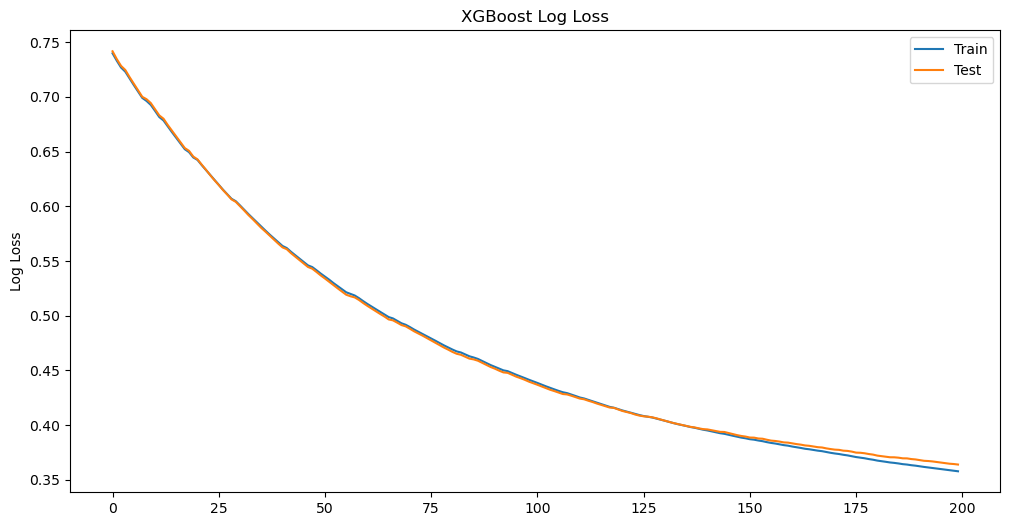

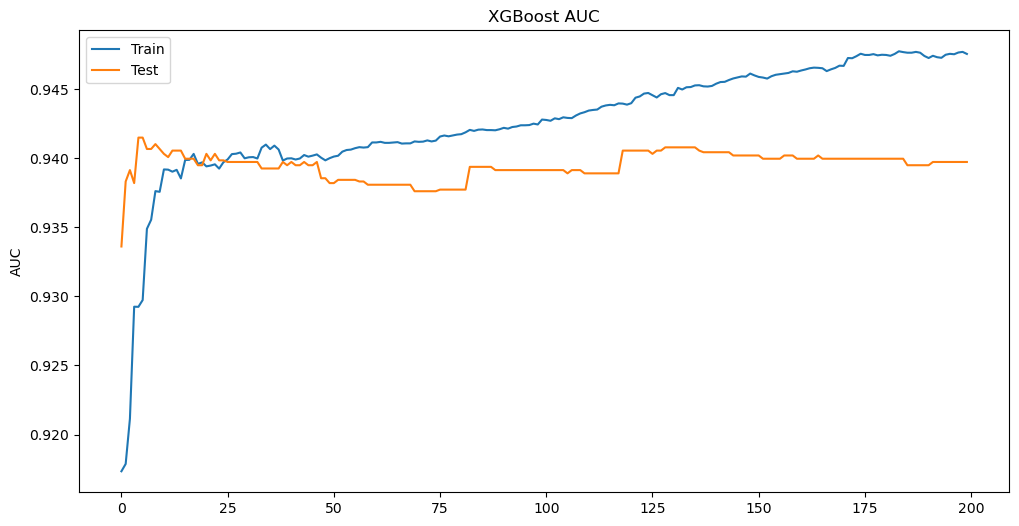

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Set up evaluation sets
eval_set = [(X_train_reduced, y_train), (X_test_reduced, y_test)]

# Train model with early stopping and record metrics
best_xgb = XGBClassifier(
    **grid.best_params_,
    scale_pos_weight=2,
    random_state=69,
    eval_metric=['logloss', 'auc']
)

best_xgb.fit(
    X_train_reduced, y_train,
    eval_set=eval_set,
    verbose=False
)

# Retrieve performance metrics
results = best_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Plot AUC
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

# If you want accuracy instead of AUC (though AUC is generally better for imbalanced data)
# You'll need to calculate this manually during training

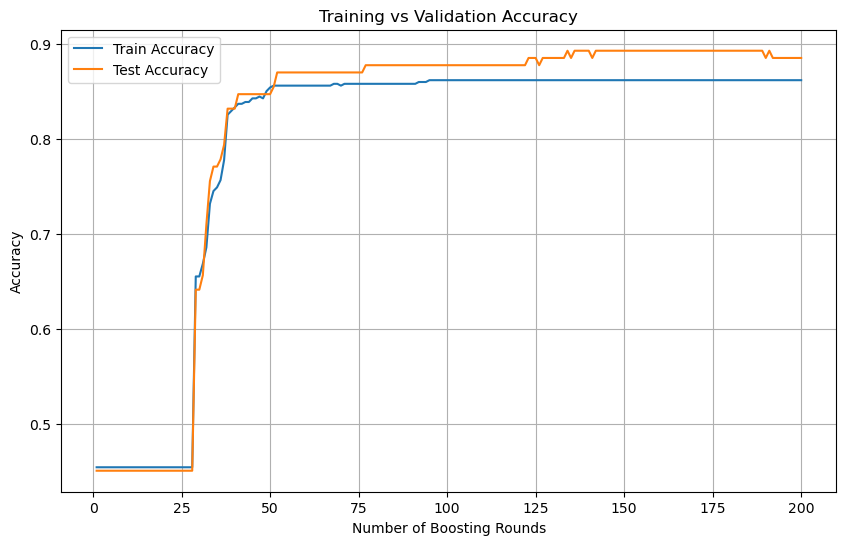

In [88]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Prepare the model with best parameters (remove n_estimators duplication)
best_params = grid.best_params_.copy()
best_params['scale_pos_weight'] = 2
best_params['random_state'] = 69

# 2. Initialize model
model = XGBClassifier(**best_params)

# 3. Prepare to store metrics
train_accuracies = []
test_accuracies = []

# 4. Train incrementally and record accuracies
for i in range(1, best_params['n_estimators'] + 1):
    model.set_params(n_estimators=i)
    model.fit(X_train_reduced, y_train)  # Note: Don't use eval_set here
    
    # Record accuracies
    train_acc = accuracy_score(y_train, model.predict(X_train_reduced))
    test_acc = accuracy_score(y_test, model.predict(X_test_reduced))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_params['n_estimators'] + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, best_params['n_estimators'] + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# PCA Plotting for XGBoost (Decision boundary doesnt look clear here)

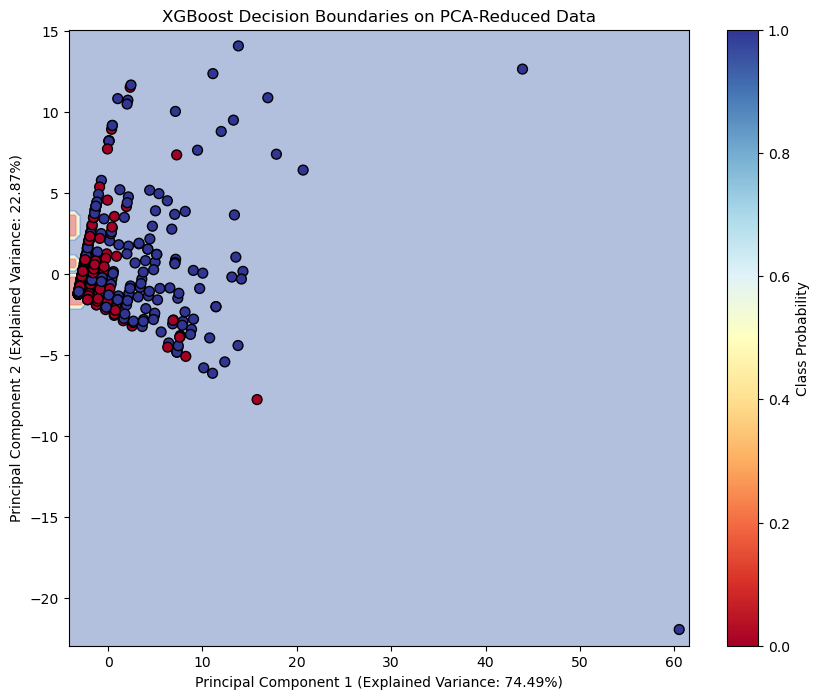

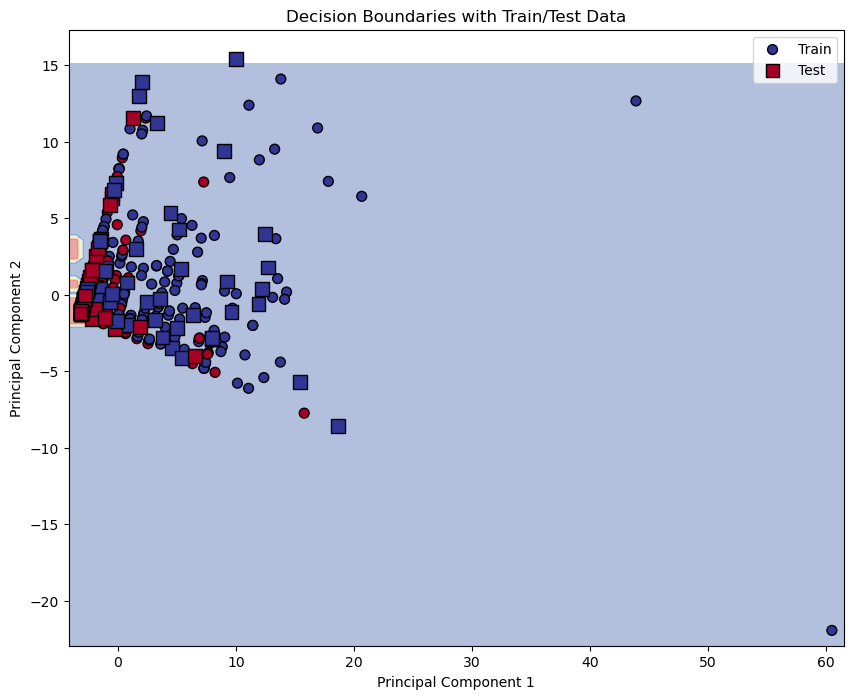

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Apply PCA to reduce to 2D components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

# 2. Train XGBoost on PCA-transformed data
pca_xgb = XGBClassifier(**best_params)
pca_xgb.fit(X_train_pca, y_train)

# 3. Create mesh grid for decision boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# 4. Predict for each mesh point
Z = pca_xgb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 5. Plot decision boundaries and training points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
            edgecolors='k', cmap='RdYlBu', s=50)
plt.xlabel('Principal Component 1 (Explained Variance: {:.2f}%)'
           .format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Principal Component 2 (Explained Variance: {:.2f}%)'
           .format(pca.explained_variance_ratio_[1]*100))
plt.title('XGBoost Decision Boundaries on PCA-Reduced Data')
plt.colorbar(label='Class Probability')
plt.show()

# 6. (Optional) Add test data points with different markers
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
            edgecolors='k', cmap='RdYlBu', s=50, label='Train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
            edgecolors='k', cmap='RdYlBu', s=100, marker='s', label='Test')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries with Train/Test Data')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


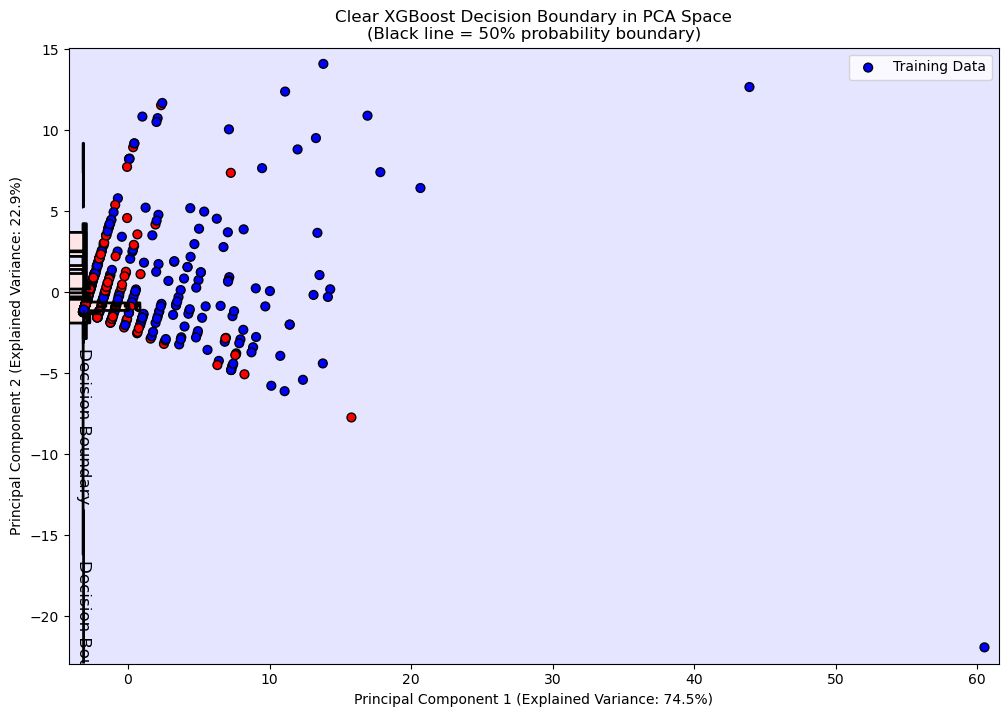

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Create a clearer colormap
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Light colors for areas
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # Bold colors for points

# 2. Create mesh grid with finer resolution
h = 0.02  # Smaller step size for smoother boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 3. Get predictions and probabilities
Z = pca_xgb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
probs = pca_xgb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
probs = probs.reshape(xx.shape)

# 4. Plot decision boundary and probability contours
plt.figure(figsize=(12, 8))

# Background colors for decision regions
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto', alpha=0.3)

# Contour line for the actual decision boundary (where probability = 0.5)
CS = plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)
plt.clabel(CS, inline=True, fontsize=12, fmt='Decision Boundary')

# Plot training points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold,
            edgecolor='k', s=40, label='Training Data')

# Add labels and title
plt.xlabel('Principal Component 1 (Explained Variance: {:.1f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Principal Component 2 (Explained Variance: {:.1f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title('Clear XGBoost Decision Boundary in PCA Space\n(Black line = 50% probability boundary)')
plt.legend()
plt.show()

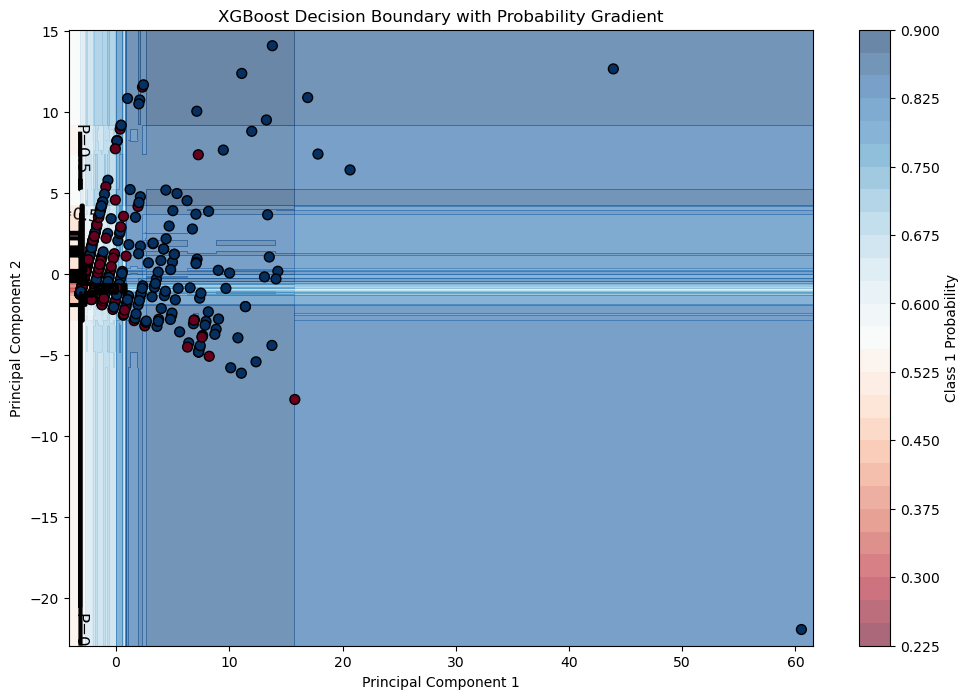

In [96]:
plt.figure(figsize=(12, 8))

# Probability heatmap
plt.contourf(xx, yy, probs, 25, cmap='RdBu', alpha=0.6)
plt.colorbar(label='Class 1 Probability')

# Decision boundary
CS = plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=3)
plt.clabel(CS, inline=True, fontsize=12, fmt='P=0.5')

# Data points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdBu',
            edgecolor='black', s=50, linewidth=1)

plt.title('XGBoost Decision Boundary with Probability Gradient')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()